<a href="https://colab.research.google.com/github/fnavab/APS360-project/blob/main/Final_16K_ANN_VGG_features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount googledrive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import numpy as np
import time
import matplotlib.pyplot as plt

In [3]:
def get_vgg_data_loader(batch_size):
  train_dir = '/content/gdrive/My Drive/Colab Notebooks/Project/APS360 GROUP/16k_vgg_features/train'
  test_dir = '/content/gdrive/My Drive/Colab Notebooks/Project/APS360 GROUP/16k_vgg_features/test'
  val_dir = '/content/gdrive/My Drive/Colab Notebooks/Project/APS360 GROUP/16k_vgg_features/val'
  train_set = torchvision.datasets.DatasetFolder(train_dir, loader=torch.load, extensions=('.tensor'))
  val_set= torchvision.datasets.DatasetFolder(val_dir, loader=torch.load, extensions=('.tensor'))
  test_set = torchvision.datasets.DatasetFolder(test_dir, loader=torch.load, extensions=('.tensor'))
  torch.manual_seed(1) # set the random seed

  num_workers = 1
  train_feature_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  test_feature_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)
  val_feature_loader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, 
                                            num_workers=num_workers, shuffle=True)


  return train_feature_loader, test_feature_loader,val_feature_loader

In [4]:
#Prepare feature loader
train_feature_loader, test_feature_loader,val_feature_loader=get_vgg_data_loader(128)

In [5]:
# Verification Step - obtain one batch of features
dataiter = iter(val_feature_loader)
features, labels = dataiter.next()
print(features.shape)
print(labels.shape)

torch.Size([128, 512, 9, 9])
torch.Size([128])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_VGG(nn.Module):
    def __init__(self):
        super(CNN_VGG, self).__init__()
        self.name="CNN_VGG"

        #self.conv1 = nn.Conv2d(512, 490, 3)
        #self.conv2 = nn.Conv2d(490, 450, 3)
        #self.conv3 = nn.Conv2d(450, 400, 3)
        #self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(512*9*9, 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        #x = F.relu(self.conv1(x))
        #x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        x = x.view(x.shape[0], 512*9*9) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = x.squeeze(1)
       
        return x

In [7]:
def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [9]:
def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [10]:
def train_net(model,target_classes,train_loader,val_loader, batch_size=64, learn_rate=0.001, num_epochs=30):
    ########################################################################
    ########################################################################
    # Fixed PyTorch random seed for reproducible result
    torch.manual_seed(1000)
    ########################################################################
    ########################################################################
    # Define the Loss function and optimizer
    # The loss function will be Cross Entropy,which will apply softmax to the output layer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learn_rate)
    

    ########################################################################
    # Set up some numpy arrays to store the training/test loss/erruracy
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    # Loop over the data iterator and sample a new batch of training data
    # Get the output from the network, and optimize our loss function.
    start_time=time.time()
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times
        total_train_loss = 0.0
        total_train_acc = 0.0
        total_epoch = 0
        for imgs, labels in iter(train_loader):

            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()

            # Forward pass, backward pass, and optimize
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Calculate the statistics
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_loss[epoch] = float(total_train_loss) / (batch_size)
        train_acc[epoch]= get_accuracy(model, train_loader)
        val_acc[epoch] = get_accuracy(model, val_loader)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+
               "Validation acc: {}").format(
                   epoch + 1,
                   train_acc[epoch],
                   train_loss[epoch],
                   val_acc[epoch]
                   ))
        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, batch_size, learn_rate, epoch)
        torch.save(model.state_dict(), model_path)
    print('Finished Training')

    end_time= time.time()

    # Write the train/test loss/err into CSV file 
    epochs = np.arange(1, num_epochs + 1)
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)


    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))
    print("Total time: " , (end_time-start_time))


    # plotting
    plt.title("Training Curve")
    plt.plot(epochs, train_loss, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(epochs, train_acc, label="Train")
    plt.plot(epochs, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    plt.show()

TO DO: Hyper parameter tuning

Epoch 1: Train acc: 0.6450466459351399, Train loss: 0.9604733847081661 |Validation acc: 0.6198791134989926
Epoch 2: Train acc: 0.7129053753887161, Train loss: 0.6700216112658381 |Validation acc: 0.6672263263935527
Epoch 3: Train acc: 0.7434473567303421, Train loss: 0.5484050079248846 |Validation acc: 0.6907320349227669
Epoch 4: Train acc: 0.7621057307863172, Train loss: 0.48187411949038506 |Validation acc: 0.7024848891873741
Epoch 5: Train acc: 0.782985339848956, Train loss: 0.4397545694373548 |Validation acc: 0.7179314976494291
Epoch 6: Train acc: 0.7963127498889383, Train loss: 0.4096717368811369 |Validation acc: 0.7269979852249832
Epoch 7: Train acc: 0.8060861839182586, Train loss: 0.3830823116004467 |Validation acc: 0.7333781061114842
Epoch 8: Train acc: 0.8143047534429143, Train loss: 0.3634493858553469 |Validation acc: 0.7360644728005373
Epoch 9: Train acc: 0.8248556197245669, Train loss: 0.3472753025125712 |Validation acc: 0.7400940228341168
Epoch 10: Train acc: 0.83051976899155

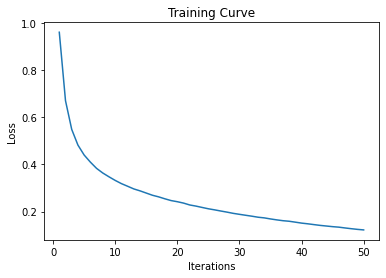

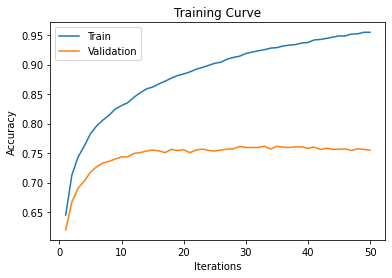

In [13]:
use_cuda = True
classes = ['Shirt', 'Jeans', 'Lounge Pants', 'Shorts', 'Skirt', 'Sweater', 'Dress', 'Jacket']

model=CNN_VGG()
#Modify
if use_cuda and torch.cuda.is_available():
    model.cuda()
train_net(model, classes,train_feature_loader, val_feature_loader, batch_size=128, num_epochs=50, learn_rate = 0.00001)

In [14]:
best_model_path = get_model_name("CNN_VGG", batch_size=128, learning_rate=0.00001, epoch=32) # epoch 33
state = torch.load(best_model_path)

best_net = CNN_VGG()
best_net.load_state_dict(state)

torch.save(best_net.state_dict(), "/content/gdrive/My Drive/Colab Notebooks/Project/VGG_76_16")

In [19]:
best_net.cuda()
get_accuracy(best_net, test_feature_loader)

0.7654075546719682

In [20]:
def get_confusion_matrix(model, data_loader):
    correct = 0
    total = 0
    nb_classes = 8

    confusion_matrix = torch.zeros(nb_classes, nb_classes)
    with torch.no_grad():

      for imgs, labels in data_loader:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()

        output = model(imgs)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        
        for t, p in zip(labels.view(-1), pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    
    print(confusion_matrix)
    print(confusion_matrix.diag()/confusion_matrix.sum(1))
    # Visualize it as a heatmap
    import seaborn
    seaborn.heatmap(confusion_matrix)
    plt.show()

tensor([[346.,  10.,   5.,   0.,  12.,   0.,   6.,  11.],
        [ 15., 291.,   0.,   2.,  19.,   5.,   9.,  34.],
        [  2.,   3., 284.,  71.,   1.,  14.,   5.,   1.],
        [  0.,   1.,  50., 287.,   1.,  13.,  19.,   1.],
        [ 10.,  23.,   0.,   1., 264.,   8.,   6.,  47.],
        [  2.,   7.,  10.,  17.,   3., 312.,  45.,   4.],
        [  4.,   7.,  10.,   6.,   2.,  67., 267.,   3.],
        [ 15.,  50.,   1.,   2.,  41.,   3.,   4., 259.]])
tensor([0.8872, 0.7760, 0.7454, 0.7715, 0.7354, 0.7800, 0.7295, 0.6907])


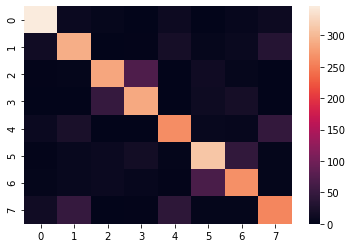

In [21]:
get_confusion_matrix(best_net, test_feature_loader)